# Error Analysis

In [1]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

out_path = Path("../output")

map_model_names = {
    "internvl3-8b": "InternVL3",
    "qwen2-vl-7b": "Qwen2-VL",
    "llava-next-interleave-7b": "LLaVA-Interleave",
    "llava-onevision-7b": "LLaVA-OneVision",
    "paligemma2-10b": "Paligemma 2",
}


def relative_improvement(
    old: float, new: float, higher_is_better: bool = True, percentage: bool = True
) -> float:
    """
    Computes the relative improvement (as a fraction).

    If higher_is_better=True, improvement is positive when new > old.
    If higher_is_better=False, improvement is positive when new < old.
    """
    if old == 0:
        raise ValueError("Old value cannot be zero (division by zero).")

    if higher_is_better:
        res = (new - old) / old
    else:
        res = (old - new) / old

    if percentage:
        res *= 100
    return res

## Per Object Analysis

In [2]:
results_per_model = []
for model in out_path.iterdir():
    results_path = (
        model / "counting_balanced_672_large_all" / "classification_report.json"
    )
    if results_path.exists():
        with open(results_path, "r") as f:
            results = json.load(f)

        results_per_model.append(
            {
                "Model": map_model_names.get(model.name, model.name),
                "Baseline": results["accuracy"],
            }
        )

In [7]:
object_mapping = {
    "squares": "s",
    "triangles": "^",
    "circles": "o",
    "stars": "*",
}

results_per_model = {}
for model in out_path.iterdir():
    report_path = model / "balanced" / "summary.json"
    if report_path.exists():
        with open(report_path, "r") as f:
            report = json.load(f)
        results_per_model[model.name] = {}
        for object_type in report:
            results_per_model[model.name][object_type] = report[object_type][
                "accuracy"
            ]

        # Prepare data for scatterplot
        x = []
        y = []
        colors = []
        shapes = []

        for object_type, accuracy in results_per_model[model.name].items():
            color, shape = object_type.split("_")
            x.append(object_type)
            y.append(accuracy)
            colors.append(color)
            shapes.append(shape)

        # Create scatterplot
        fig, ax = plt.subplots(figsize=(8, 5))  # Increase figure size

        # Sort data based on color order
        color_order = ["red", "green", "blue", "cyan", "magenta", "yellow"]
        sorted_indices = sorted(
            range(len(colors)), key=lambda i: color_order.index(colors[i])
        )

        x = [x[i] for i in sorted_indices]
        y = [y[i] for i in sorted_indices]
        colors = [colors[i] for i in sorted_indices]
        shapes = [shapes[i] for i in sorted_indices]

        for color, shape in zip(colors, shapes):
            indices = [
                i
                for i, (c, s) in enumerate(zip(colors, shapes))
                if c == color and s == shape
            ]
            ax.scatter(
                [x[i] for i in indices],
                [y[i] for i in indices],
                label=f"{color} {shape}",
                alpha=0.7,
                marker=object_mapping[shape],  # type: ignore
                color=color,
                edgecolors="black",
                s=200,
            )

        ax.set_xlabel("Object Type")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"Scatterplot for {model.name}")
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.set_xticks([])
        plt.tight_layout()
        plt.savefig(model / "accuracy_per_object.png", dpi=300)
        plt.close()

        # Barplot clustering results per shape
        shape_accuracies = {shape: [] for shape in object_mapping.keys()}
        for object_type, accuracy in results_per_model[model.name].items():
            _, shape = object_type.split("_")
            shape_accuracies[shape].append(accuracy)

        fig, ax = plt.subplots(figsize=(8, 5))
        for shape, accuracies in shape_accuracies.items():
            ax.bar(
                shape,
                sum(accuracies) / len(accuracies),
                label=shape,
                alpha=0.7,
                edgecolor="black",
            )
        ax.set_xlabel("Shape")
        ax.set_ylabel("Average Accuracy")
        ax.set_title(f"Average Accuracy per Shape for {model.name}")
        plt.tight_layout()
        plt.savefig(model / "average_accuracy_per_shape.png", dpi=300)

        plt.close()

        # Barplot clustering results per color
        color_accuracies = {color: [] for color in color_order}
        for object_type, accuracy in results_per_model[model.name].items():
            color, _ = object_type.split("_")
            color_accuracies[color].append(accuracy)

        fig, ax = plt.subplots(figsize=(8, 5))
        for color, accuracies in color_accuracies.items():
            ax.bar(
                color,
                sum(accuracies) / len(accuracies),
                label=color,
                color=color,
                alpha=0.7,
                edgecolor="black",
            )
        ax.set_xlabel("Color")
        ax.set_ylabel("Average Accuracy")
        ax.set_title(f"Average Accuracy per Color for {model.name}")
        plt.tight_layout()
        plt.close()

In [8]:
import pandas as pd

pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.max_rows", None)  # Show all rows

df = pd.DataFrame(results_per_model).T
df = df.rename_axis("Model").reset_index()
color_order = ["red", "green", "blue", "cyan", "magenta", "yellow"]
sorted_columns = ["Model"] + sorted(
    df.columns[1:], key=lambda col: (color_order.index(col.split("_")[0]), col)
)
df = df[sorted_columns]
df = df.sort_values(by="Model").reset_index(drop=True)  # type: ignore
df.set_index("Model", inplace=True)

In [9]:
# Group columns by shape and compute the average
shape_columns = ["squares", "circles", "triangles", "stars"]
average_per_shape_per_model = df.groupby("Model")[
    [
        col
        for col in df.columns
        if any(col.endswith(f"_{shape}") for shape in shape_columns)
    ]
].apply(
    lambda group: {
        shape: group[[col for col in group.columns if col.endswith(f"_{shape}")]]
        .mean()
        .mean()
        for shape in shape_columns
    }
)

# Convert the series of dictionaries into a DataFrame for better visualization
average_per_shape_df = pd.DataFrame(
    average_per_shape_per_model.tolist(), index=average_per_shape_per_model.index
)
tmp = (average_per_shape_df * 100).round(2)

# Add average and standard deviation for each column as the last row
avg_row = tmp.mean(axis=0)
std_row = tmp.std(axis=0)
tmp.loc["Average"] = avg_row
tmp.loc["STD"] = std_row
tmp.round(2)

,squares,circles,triangles,stars
Model,,,,
CLIP,25.67,22.84,6.72,26.86
CoCa,37.84,56.40,50.80,47.60
internvl3-8b,35.44,56.72,61.32,55.83
llava-next-interleave-7b,44.40,52.26,40.81,45.15
llava-onevision-7b,60.63,74.10,71.95,63.17
paligemma2-10b,73.78,73.39,76.66,75.63
qwen2-vl-7b,54.64,67.76,66.48,69.98
Average,47.49,57.64,53.53,54.89
STD,16.53,17.62,24.02,16.64


In [10]:
# Group columns by color and compute the average
color_columns = ["red", "green", "blue", "cyan", "magenta", "yellow"]
average_per_color_per_model = df.groupby("Model")[
    [col for col in df.columns if any(col.startswith(color) for color in color_columns)]
].apply(
    lambda group: {
        color: group[[col for col in group.columns if col.startswith(color)]]
        .mean()
        .mean()
        for color in color_columns
    }
)

# Convert the series of dictionaries into a DataFrame for better visualization
average_per_color_df = pd.DataFrame(
    average_per_color_per_model.tolist(), index=average_per_color_per_model.index
)
tmp = (average_per_color_df * 100).round(2)

# Add average and standard deviation for each column as the last row
avg_row = tmp.mean(axis=0)
std_row = tmp.std(axis=0)
tmp.loc["Average"] = avg_row
tmp.loc["STD"] = std_row
tmp.round(2)

,red,green,blue,cyan,magenta,yellow
Model,,,,,,
CLIP,19.62,17.80,23.56,22.22,18.90,21.06
CoCa,51.95,42.94,46.50,50.10,49.76,47.70
internvl3-8b,55.93,49.83,50.41,51.78,53.60,52.40
llava-next-interleave-7b,46.98,46.57,45.92,44.14,45.61,44.72
llava-onevision-7b,68.00,67.80,69.34,66.43,68.55,64.64
paligemma2-10b,73.59,73.73,76.65,73.46,76.41,75.34
qwen2-vl-7b,65.40,63.99,66.46,62.14,66.22,64.09
Average,54.50,51.81,54.12,52.90,54.15,52.85
STD,18.01,18.94,18.09,16.92,19.08,17.68


## Overall results

In [11]:
results_per_model_per_digit = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    report_path = (
        model / "balanced" / "classification_report.json"
    )
    if report_path.exists():
        with open(report_path, "r") as f:
            report = json.load(f)
        results_per_model_per_digit[model_name] = {}
        for digit, res in report.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            results_per_model_per_digit[model_name][int(digit)] = (
                res["f1-score"] * 100
            )

### Per-Digit Accuracy

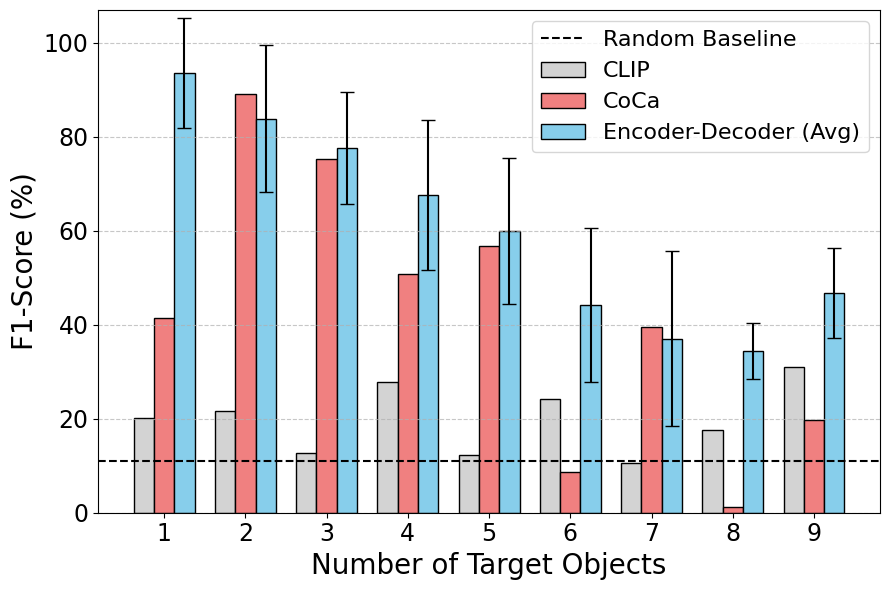

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

# Bar positions
x = range(1, 10)
width = 0.25

clip_avg = [results_per_model_per_digit["CLIP"][d] for d in x]
coca_avg = [results_per_model_per_digit["CoCa"][d] for d in x]
encoder_decoder_avg = [
    np.mean(
        [
            results_per_model_per_digit[model][d]
            for model in results_per_model_per_digit
            if model not in ["CLIP", "CoCa"]
        ]
    )
    for d in x
]
encoder_decoder_std = [
    np.std(
        [
            results_per_model_per_digit[model][d]
            for model in results_per_model_per_digit
            if model not in ["CLIP", "CoCa"]
        ]
    )
    for d in x
]

# Plot bars
ax.bar(
    [i - width for i in x],
    clip_avg,
    width,
    capsize=5,
    label="CLIP",
    color="lightgray",
    edgecolor="black",
)
ax.bar(
    x, coca_avg, width, capsize=5, label="CoCa", color="lightcoral", edgecolor="black"
)
ax.bar(
    [i + width for i in x],
    encoder_decoder_avg,
    width,
    yerr=encoder_decoder_std,
    capsize=5,
    label="Encoder-Decoder (Avg)",
    color="skyblue",
    edgecolor="black",
)


ax.axhline(y=11.11, color="black", linestyle="--", label="Random Baseline")
ax.set_xlabel("Number of Target Objects", fontsize=20)
ax.set_ylabel("F1-Score (%)", fontsize=20)
ax.tick_params(axis="both", labelsize=17)
ax.set_xticks(x)
ax.legend(fontsize=16, loc="best")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0, 107)  # Set y-axis limit to 0-1 for percentage
fig.set_size_inches(9, 6)
plt.tight_layout()
plt.savefig(out_path / "f1_score_per_number_of_target_objects_models.pdf", dpi=300)

### Clustered vs. Scattered

In [13]:
cvs_stats = []
for model in out_path.iterdir():
    if model.name != "ablations":
        clustered_path = (
            model / "clustered" / "classification_report.json"
        )
        scattered_path = (
            model / "scattered" / "classification_report.json"
        )
        if scattered_path.exists() and clustered_path.exists():
            with open(clustered_path, "r") as f:
                report_clustered = json.load(f)

            with open(scattered_path, "r") as f:
                report_scattered = json.load(f)

            cvs_stats.append(
                {
                    "Model": model.name,
                    "Clustered": report_clustered["accuracy"],
                    "Scattered": report_scattered["accuracy"],
                }
            )
df = pd.DataFrame(cvs_stats)
df = df.sort_values(by="Model").reset_index(drop=True)
df.set_index("Model", inplace=True)
df.loc["Average"] = df.mean()
df = (df * 100).round(2)
df

,Clustered,Scattered
Model,,
CLIP,25.10,27.46
CoCa,66.45,61.08
internvl3-8b,66.85,55.12
llava-next-interleave-7b,57.30,44.08
llava-onevision-7b,73.00,72.37
paligemma2-10b,59.82,77.56
qwen2-vl-7b,65.32,62.56
Average,59.12,57.18


### Open- vs. Closed-ended

In [14]:
results_per_model_per_digit = {}
for model in out_path.iterdir():
    if model.name != "ablations":
        closed_ended_path = (
            model / "balanced" / "classification_report.json"
        )
        open_ended_path = model / "open-ended" / "classification_report.json"
        if open_ended_path.exists() and closed_ended_path.exists():
            with open(closed_ended_path, "r") as f:
                closed_ended = json.load(f)

            with open(open_ended_path, "r") as f:
                open_ended = json.load(f)

            results_per_model_per_digit[model.name] = {
                "closed-ended": {},
                "open-ended": {},
            }
            for digit, res in closed_ended.items():
                if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                    continue
                results_per_model_per_digit[model.name]["closed-ended"][int(digit)] = (
                    res["f1-score"]
                )

            for digit, res in open_ended.items():
                if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                    continue
                results_per_model_per_digit[model.name]["open-ended"][int(digit)] = res[
                    "f1-score"
                ]

In [15]:
results_per_model = {}
for model in out_path.iterdir():
    closed_ended_path = (
        model / "balanced" / "classification_report.json"
    )
    open_ended_path = model / "open-ended" / "classification_report.json"
    if open_ended_path.exists() and closed_ended_path.exists():
        with open(closed_ended_path, "r") as f:
            closed_ended = json.load(f)

        with open(open_ended_path, "r") as f:
            open_ended = json.load(f)

        results_per_model[model.name] = (
            closed_ended["accuracy"] - open_ended["accuracy"]
        )


df = pd.DataFrame(results_per_model.items(), columns=["Model", "Delta"])
df = df.sort_values(by="Model").reset_index(drop=True)
df = df.set_index("Model")
df = df.rename_axis("Model").reset_index()
df["Delta"] = (df["Delta"] * 100).round(2)
df

,Model,Delta
0,internvl3-8b,-4.85
1,llava-next-interleave-7b,5.56
2,llava-onevision-7b,0.74
3,paligemma2-10b,-4.90
4,qwen2-vl-7b,-1.46


In [16]:
results_per_model_per_digit = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    report_path = (
        model / "balanced" / "classification_report.json"
    )
    if report_path.exists():
        with open(report_path, "r") as f:
            report = json.load(f)
        results_per_model_per_digit[model_name] = {}
        for digit, res in report.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            results_per_model_per_digit[model_name][int(digit)] = (
                res["f1-score"] * 100
            )


results_per_model_per_digit_open_ended = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    report_path = model / "open-ended" / "classification_report.json"
    if report_path.exists():
        with open(report_path, "r") as f:
            report = json.load(f)
        results_per_model_per_digit_open_ended[model_name] = {}
        for digit, res in report.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            results_per_model_per_digit_open_ended[model_name][int(digit)] = (
                res["f1-score"] * 100
                )

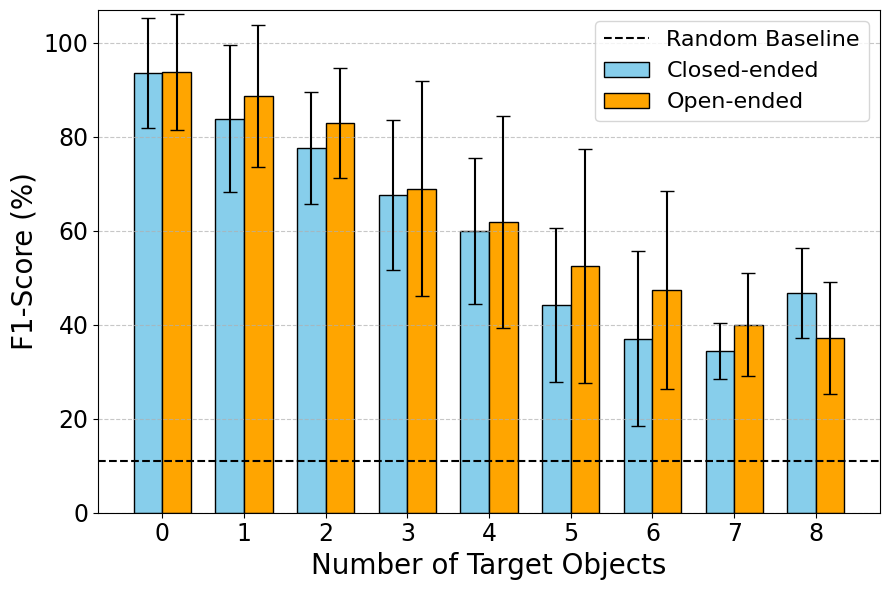

In [18]:
import numpy as np
import matplotlib.pyplot as plt

digits = list(range(1, 10))

# Prepare closed-ended data
all_models = [
    v for k, v in results_per_model_per_digit.items() if k not in ["CLIP", "CoCa"]
]
closed_values = np.array([[model[d] for d in digits] for model in all_models])
closed_avg = closed_values.mean(axis=0)
closed_std = closed_values.std(axis=0)

# Prepare open-ended data
open_models = [v for k, v in results_per_model_per_digit_open_ended.items()]
open_values = np.array([[model[d] for d in digits] for model in open_models])
open_avg = open_values.mean(axis=0)
open_std = open_values.std(axis=0)

x = np.arange(len(digits))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(
    x - width / 2,
    closed_avg,
    width,
    yerr=closed_std,
    capsize=5,
    color="skyblue",
    edgecolor="black",
    label="Closed-ended",
)
ax.bar(
    x + width / 2,
    open_avg,
    width,
    yerr=open_std,
    capsize=5,
    color="orange",
    edgecolor="black",
    label="Open-ended",
)

ax.axhline(y=11.11, color="black", linestyle="--", label="Random Baseline")
ax.set_xlabel("Number of Target Objects", fontsize=20)
ax.set_ylabel("F1-Score (%)", fontsize=20)
# ax.set_title("F1-Score per Number of Target Objects (Closed- vs Open-ended questions)", fontsize=15)
ax.tick_params(axis="both", labelsize=17)
ax.set_xticks(x)
ax.legend(fontsize=16, loc="best")
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_ylim(0, 107)  # Set y-axis limit to 0-1 for percentage
fig.set_size_inches(9, 6)
plt.tight_layout()
plt.savefig(
    out_path / "closed_vs_open_ended_f1_score_per_number_of_target_objects.pdf", dpi=300
)

### MAE and RMSE

In [19]:
results_per_model = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    results_path = model / "balanced" / "results.json"
    if results_path.exists():
        with open(results_path, "r") as f:
            results = json.load(f)

        y_true = []
        y_pred = []
        results_per_model[model_name] = {}
        for img_id, entities in results.items():
            for ent_type, question_types in entities.items():
                for q_type, q_res in question_types.items():
                    if "pred" not in q_res:
                        for sub_q_type, _ in q_res.items():
                            y_true.append(q_res[sub_q_type]["target"])
                            y_pred.append(q_res[sub_q_type]["pred"])
                    else:
                        y_true.append(q_res["target"])
                        y_pred.append(q_res["pred"])
        results_per_model[model_name] = {
            "y_true": y_true,
            "y_pred": y_pred,
        }

In [20]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

stats = []
for model in results_per_model:
    y_true = results_per_model[model]["y_true"]
    y_pred = results_per_model[model]["y_pred"]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    stats.append({"Model": model, "MAE": mae, "RMSE": rmse})

df = pd.DataFrame(stats)
df = df.sort_values(by="Model").reset_index(drop=True)
df = df.set_index("Model")
df

,MAE,RMSE
Model,,
CLIP,2.114255,2.993487
CoCa,2.056984,3.509744
InternVL3,0.627801,0.990351
LLaVA-Interleave,1.012003,1.622142
LLaVA-OneVision,0.373114,0.688182
Paligemma 2,0.272176,0.567566
Qwen2-VL,0.391347,0.686477


In [21]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

digits = sorted(set(y_true)) 

mae_per_digit = {}
rmse_per_digit = {}

for model, res in results_per_model.items():
    y_true_arr = np.array(res["y_true"])
    y_pred_arr = np.array(res["y_pred"])
    mae_dict = {}
    rmse_dict = {}
    for digit in digits:
        mask = y_true_arr == digit
        if np.any(mask):
            mae_dict[digit] = mean_absolute_error(y_true_arr[mask], y_pred_arr[mask])
            rmse_dict[digit] = root_mean_squared_error(
                y_true_arr[mask], y_pred_arr[mask]
            )
        else:
            mae_dict[digit] = np.nan
            rmse_dict[digit] = np.nan
    mae_per_digit[model] = mae_dict
    rmse_per_digit[model] = rmse_dict

mae_df = pd.DataFrame(mae_per_digit).T
rmse_df = pd.DataFrame(rmse_per_digit).T

# Combine into a single MultiIndex DataFrame for display
multi_df = pd.concat({"MAE": mae_df, "RMSE": rmse_df}, axis=1)
multi_df.index.name = "Model"
multi_df.columns.names = ["Metric", "Digit"]
multi_df.round(3)

Metric              MAE                                                   \
Digit                 1      2      3      4      5      6      7      8   
Model                                                                      
CLIP              0.967  1.004  1.296  1.750  2.395  2.420  2.814  3.062   
Paligemma 2       0.006  0.060  0.045  0.158  0.286  0.154  0.521  0.682   
InternVL3         0.458  0.493  0.500  0.650  0.590  0.447  0.604  0.878   
LLaVA-Interleave  0.008  0.415  0.412  1.210  1.734  1.970  1.598  0.772   
CoCa              0.087  0.094  0.075  0.720  1.111  2.590  3.174  4.579   
Qwen2-VL          0.001  0.083  0.249  0.338  0.420  0.705  0.346  0.575   
LLaVA-OneVision   0.000  0.084  0.130  0.214  0.378  0.725  0.361  0.721   

Metric                    RMSE                                            \
Digit                 9      1      2      3      4      5      6      7   
Model                                                                      
CLIP              3.322  1.374  1.151  1.462  2.202  2.839  3.192  3.640   
Paligemma 2       0.537  0.111  0.244  0.294  0.456  0.589  0.441  0.755   
InternVL3         1.030  0.678  0.806  0.968  1.178  1.033  0.894  0.875   
LLaVA-Interleave  0.990  0.091  0.827  1.052  1.846  2.251  2.215  1.794   
CoCa              6.083  0.296  0.307  0.277  1.004  1.977  3.278  4.303   
Qwen2-VL          0.805  0.032  0.294  0.511  0.619  0.788  0.878  0.629   
LLaVA-OneVision   0.745  0.000  0.290  0.361  0.476  0.677  0.906  0.730   

Metric                          
Digit                 8      9  
Model                           
CLIP              4.142  4.669  
Paligemma 2       0.872  0.813  
InternVL3         1.007  1.321  
LLaVA-Interleave  1.433  1.797  
CoCa              5.445  6.839  
Qwen2-VL          0.778  1.056  
LLaVA-OneVision   0.912  1.086

## Distractors

### Plot

In [39]:
category_order = {
    "distractor_type": [
        "small_red_star",
        "large_red_star",
        "large_red_circle",
        "large_magenta_star",
    ]
}

accuracies = []

for model in [
    "llava-next-interleave-7b",
    "llava-onevision-7b",
    "qwen2-vl-7b",
    "paligemma2-10b",
    "internvl3-8b",
    "CLIP",
    "CoCa",
]:
    for folder in Path(f"../output/{model}").iterdir():
        if "distractors" in folder.name:
            n_distractors = folder.name.split("distractors_")[-1].split("_")[0]
            distractor_type = folder.name.split(f"{n_distractors}_")[-1]
            if distractor_type not in category_order["distractor_type"]:
                continue
            results_path = f"{folder}/classification_report.json"

            with open(results_path) as f:
                data = json.load(f)
            accuracies.append(
                {
                    "model": model,
                    "n_distractors": int(n_distractors),
                    "distractor_type": distractor_type,
                    "accuracy": (
                        data["accuracy"]
                        if "accuracy" in data
                        else data["micro avg"]["f1-score"]
                    ),
                }
            )

In [40]:
results_per_model = []
for model in out_path.iterdir():
    results_path = (
        model
        / "balanced"
        / "magenta_circles"
        / "classification_report.json"
    )
    if results_path.exists():
        with open(results_path, "r") as f:
            results = json.load(f)

        results_per_model.append(
            {"Model": model.name, "Baseline": results["accuracy"]}
        )

baseline_df = pd.DataFrame(results_per_model)
baseline_df = baseline_df.sort_values(by="Model").set_index("Model")
baseline_df.loc["Average"] = baseline_df.mean()
(baseline_df * 100).round(2)

,Baseline
Model,
CLIP,17.97
CoCa,58.71
internvl3-8b,60.77
llava-next-interleave-7b,53.64
llava-onevision-7b,73.66
paligemma2-10b,76.54
qwen2-vl-7b,73.25
Average,59.22


In [41]:
accuracies_df = pd.DataFrame(accuracies)

accuracies_df = accuracies_df.sort_values(
    by=["model", "n_distractors", "distractor_type"], ascending=[True, True, True]
).reset_index(drop=True)

avg_accuracy = (
    accuracies_df.groupby(["model", "distractor_type"])["accuracy"].mean().unstack()
)
avg_accuracy = avg_accuracy[category_order["distractor_type"]]
avg_row = avg_accuracy.mean(axis=0)
avg_accuracy.loc["Average"] = avg_row
(avg_accuracy * 100).round(2)

distractor_type,small_red_star,large_red_star,large_red_circle,large_magenta_star
model,,,,
CLIP,17.48,16.17,14.11,15.15
CoCa,23.87,14.97,9.77,14.46
internvl3-8b,68.31,67.49,58.57,63.60
llava-next-interleave-7b,38.61,37.65,30.42,30.09
llava-onevision-7b,57.95,54.17,37.89,50.08
paligemma2-10b,66.68,64.15,56.59,60.39
qwen2-vl-7b,43.73,48.91,45.51,46.01
Average,45.23,43.36,36.12,39.97


In [42]:
accuracies_df = pd.DataFrame(accuracies)

accuracies_df = accuracies_df.sort_values(
    by=["model", "n_distractors", "distractor_type"], ascending=[True, True, True]
).reset_index(drop=True)

avg_accuracy = (
    accuracies_df.groupby(["model", "n_distractors"])["accuracy"].mean().unstack()
)
avg_row = avg_accuracy.mean(axis=0)
avg_accuracy.loc["Average"] = avg_row
(avg_accuracy * 100).round(2)

n_distractors,1,5,9
model,,,
CLIP,15.99,15.32,15.88
CoCa,26.98,10.79,9.53
internvl3-8b,61.67,65.07,66.75
llava-next-interleave-7b,36.98,32.91,32.68
llava-onevision-7b,60.73,48.50,40.83
paligemma2-10b,70.03,60.19,55.65
qwen2-vl-7b,45.47,45.20,47.45
Average,45.41,39.71,38.40


## Fine-tuning

In [2]:
synth_ft_res = []
for model in [
    "llava-next-interleave-7b",
    "llava-onevision-7b",
    "qwen2-vl-7b",
    "paligemma2-10b",
    "internvl3-8b",
]:
    with open(
        f"{out_path}/{model}/balanced/classification_report.json"
    ) as f:
        data = json.load(f)

        digit_res = {"Model": model, "Type": "Pre-Trained"}
        for digit, res in data.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            digit_res[digit] = res["f1-score"]

        synth_ft_res.append(digit_res)

    with open(f"{out_path}/{model}/training/synthetic/test-synth-data/classification_report.json") as f:
        data = json.load(f)

        digit_res = {"Model": model, "Type": "Fine-Tuned"}
        for digit, res in data.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            digit_res[digit] = res["f1-score"]

        synth_ft_res.append(digit_res)

In [3]:
real_ft_res = []
for model in [
    "llava-next-interleave-7b",
    "llava-onevision-7b",
    "qwen2-vl-7b",
    "paligemma2-10b",
    "internvl3-8b",
]:
    with open(
        f"{out_path}/{model}/baseline/pixmo-count/classification_report.json"
    ) as f:
        data = json.load(f)

        digit_res = {"Model": model, "Type": "Pre-Trained"}
        for digit, res in data.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            digit_res[digit] = res["f1-score"]

        real_ft_res.append(digit_res)

    with open(f"{out_path}/{model}/training/real-world/test-real-data/classification_report.json") as f:
        data = json.load(f)

        digit_res = {"Model": model, "Type": "Fine-Tuned"}
        for digit, res in data.items():
            if digit in ["accuracy", "micro avg", "macro avg", "weighted avg"]:
                continue
            digit_res[digit] = res["f1-score"]

        real_ft_res.append(digit_res)

In [4]:
synth_baseline_per_model = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    if model_name not in ["CLIP", "CoCa"]:
        results_path = model / "balanced" / "results.json"
        if results_path.exists():
            with open(results_path, "r") as f:
                results = json.load(f)

            y_true = []
            y_pred = []
            synth_baseline_per_model[model_name] = {}
            for img_id, entities in results.items():
                for ent_type, question_types in entities.items():
                    for q_type, q_res in question_types.items():
                        if "pred" not in q_res:
                            for sub_q_type, _ in q_res.items():
                                y_true.append(q_res[sub_q_type]["target"])
                                y_pred.append(q_res[sub_q_type]["pred"])
                        else:
                            y_true.append(q_res["target"])
                            y_pred.append(q_res["pred"])
            synth_baseline_per_model[model_name] = {
                "y_true": y_true,
                "y_pred": y_pred,
            }

synth_ft_per_model = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    results_path = model / "training" / "synthetic" / "test-synth-data" / "results.json"
    if results_path.exists():
        with open(results_path, "r") as f:
            results = json.load(f)

        y_true = []
        y_pred = []
        synth_ft_per_model[model_name] = {}
        for img_id, entities in results.items():
            for ent_type, question_types in entities.items():
                for q_type, q_res in question_types.items():
                    if "pred" not in q_res:
                        for sub_q_type, _ in q_res.items():
                            y_true.append(q_res[sub_q_type]["target"])
                            y_pred.append(q_res[sub_q_type]["pred"])
                    else:
                        y_true.append(q_res["target"])
                        y_pred.append(q_res["pred"])
        synth_ft_per_model[model_name] = {
            "y_true": y_true,
            "y_pred": y_pred,
        }

In [6]:
import json
from pathlib import Path

out_path = Path("../output")

real_baseline_per_model = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    if model_name not in ["CLIP", "CoCa"]:
        results_path = model / "baseline" / "pixmo-count" / "results.json"
        if results_path.exists():
            with open(results_path, "r") as f:
                results = json.load(f)

            y_true = []
            y_pred = []
            real_baseline_per_model[model_name] = {}
            for img_id, sample in results.items():
                y_true.append(sample["target"])
                y_pred.append(sample["pred"])
            real_baseline_per_model[model_name] = {
                "y_true": y_true,
                "y_pred": y_pred,
            }

real_ft_per_model = {}
for model in out_path.iterdir():
    model_name = map_model_names.get(model.name, model.name)
    if model_name != "ablations":
        results_path = model / "training" / "real-world" / "test-real-data" / "results.json"
        if results_path.exists():
            with open(results_path, "r") as f:
                results = json.load(f)

            y_true = []
            y_pred = []
            real_ft_per_model[model_name] = {}
            for img_id, sample in results.items():
                y_true.append(sample["target"])
                y_pred.append(sample["pred"])
            real_ft_per_model[model_name] = {
                "y_true": y_true,
                "y_pred": y_pred,
            }

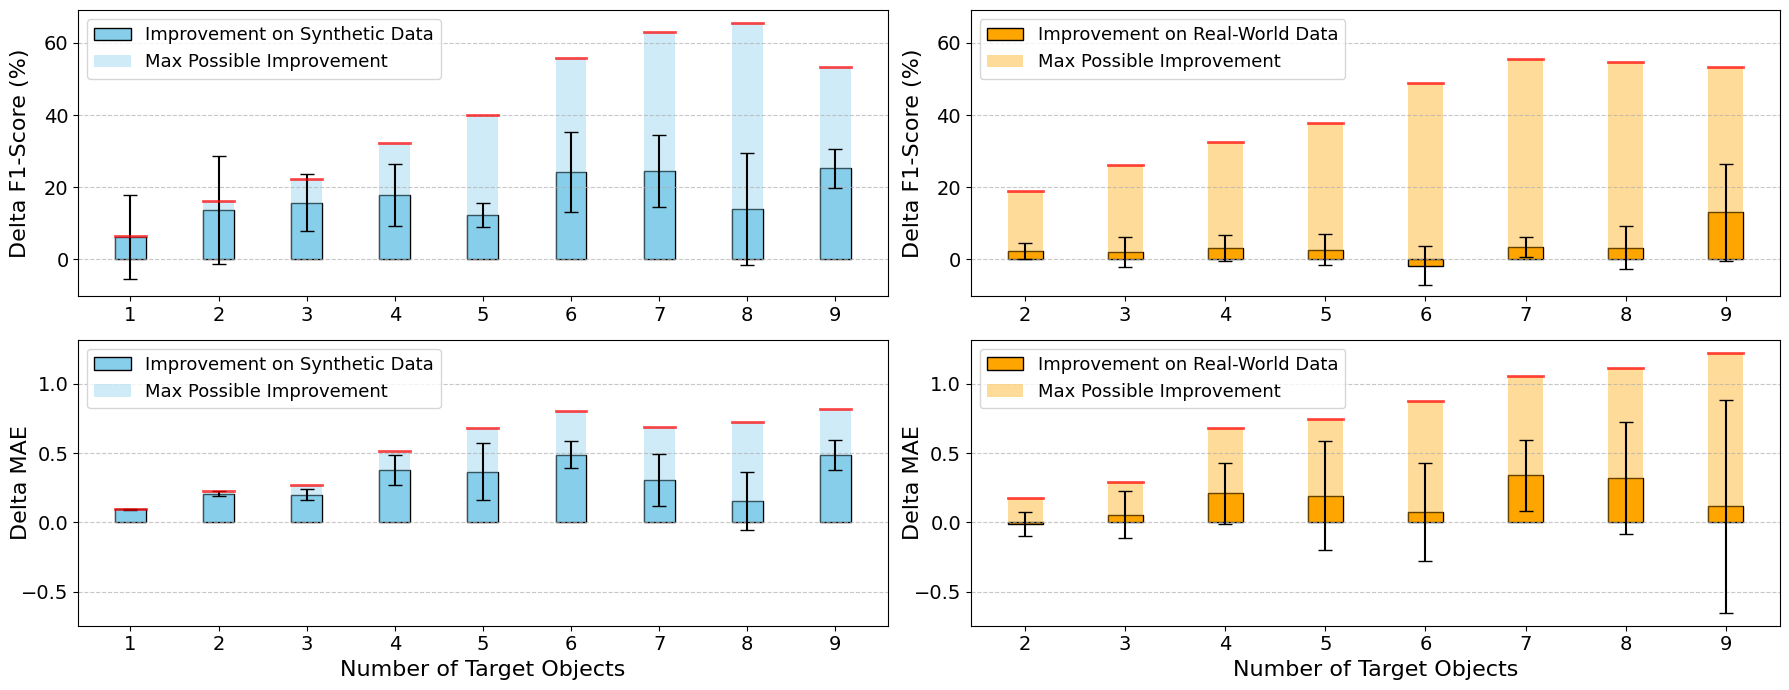

In [8]:
import numpy as np

import matplotlib.pyplot as plt

synth_df = pd.DataFrame(synth_ft_res).set_index(["Model", "Type"])
diff_synth_df = synth_df.xs("Fine-Tuned", level="Type") - synth_df.xs(
    "Pre-Trained", level="Type"
)
real_df = pd.DataFrame(real_ft_res).set_index(["Model", "Type"])
diff_real_df = real_df.xs("Fine-Tuned", level="Type") - real_df.xs(
    "Pre-Trained", level="Type"
)

# Compute standard deviation across models for each digit
std_per_digit = diff_real_df.std(axis=0) * 100

# Prepare data
digits = [str(d) for d in range(1, 10)]
width = 0.35

real_means = []
synth_means = []
real_stds = []
synth_stds = []

for digit in digits:
    if digit in diff_real_df.columns:
        real_vals = diff_real_df[digit].values * 100 # type: ignore
        real_means.append(np.mean(real_vals))
        real_stds.append(np.std(real_vals))
    synth_vals = diff_synth_df[digit].values * 100 # type: ignore
    synth_means.append(np.mean(synth_vals))
    synth_stds.append(np.std(synth_vals))

x = np.arange(len(digits))

# Compute the maximum possible gain for each digit (column)
# For synthetic: 100 - baseline (since baseline is accuracy/f1 before fine-tuning)
max_gain_synth = []
for i, digit in enumerate(digits):
    if digit in synth_df.columns:
        baseline_vals = synth_df.xs("Pre-Trained", level="Type")[digit].values * 100 # type: ignore
        max_gain_synth.append(100 - np.mean(baseline_vals))
    else:
        max_gain_synth.append(np.nan)

# For real: 100 - baseline (since baseline is accuracy/f1 before fine-tuning)
max_gain_real = []
for i, digit in enumerate(digits[1:]):  # real only has digits 2-9
    if digit in real_df.columns:
        baseline_vals = real_df.xs("Pre-Trained", level="Type")[digit].values * 100 # type: ignore
        max_gain_real.append(100 - np.mean(baseline_vals))
    else:
        max_gain_real.append(np.nan)

# --- Plot ---
fig, axs = plt.subplots(
    2, 2, figsize=(18, 7), sharex=False, gridspec_kw={"height_ratios": [1, 1]}
)

ax_synth = axs[0][0]
ax_synth.bar(
    x,
    synth_means,
    width,
    yerr=synth_stds,
    capsize=5,
    label="Improvement on Synthetic Data",
    color="skyblue",
    edgecolor="black",
)
bars_synth = ax_synth.bar(
    x,
    max_gain_synth,
    width,
    color="skyblue",
    alpha=0.4,
    label="Max Possible Improvement",
)
# Add red edge only on top, with transparency
for bar in bars_synth:
    x0 = bar.get_x()
    w = bar.get_width()
    y = bar.get_height()
    ax_synth.plot([x0, x0 + w], [y, y], color="red", linewidth=2, alpha=0.7)
ax_synth.set_ylabel("Delta F1-Score (%)", fontdict={"fontsize": 16}, labelpad=10)
ax_synth.tick_params(axis="both", labelsize=14)
ax_synth.grid(axis="y", linestyle="--", alpha=0.7)
ax_synth.set_xticks(x)
ax_synth.set_xticklabels(digits)
ax_synth.legend(fontsize=13, loc="upper left")

# Real subplot (bottom)
x_real = x[1:]
digits_real = digits[1:]
ax_real = axs[0][1]
ax_real.bar(
    x_real,
    real_means,
    width,
    yerr=real_stds,
    capsize=5,
    label="Improvement on Real-World Data",
    color="orange",
    edgecolor="black",
)
bars_real = ax_real.bar(
    x_real,
    max_gain_real,
    width,
    color="orange",
    alpha=0.4,
    label="Max Possible Improvement",
)
for bar in bars_real:
    x0 = bar.get_x()
    w = bar.get_width()
    y = bar.get_height()
    ax_real.plot([x0, x0 + w], [y, y], color="red", linewidth=2, alpha=0.7)
# The ylabel may appear distant from the y-axis if the default labelpad is large, or if the tick labels are long or rotated.
# You can control the distance using the 'labelpad' parameter:
ax_real.set_ylabel("Delta F1-Score (%)", fontdict={"fontsize": 16}, labelpad=10)
ax_real.tick_params(axis="both", labelsize=14)
ax_real.grid(axis="y", linestyle="--", alpha=0.7)
ax_real.set_xticks(x_real)
ax_real.set_xticklabels(digits_real)
ax_real.legend(fontsize=13)
# ax_real.set_ylim(bottom=-30)

min_val_0, max_val_0 = ax_synth.get_ylim()
min_val_1, max_val_1 = ax_real.get_ylim()
# Set same y-limits for both MAE plots
overall_min = min(min_val_0, min_val_1)
overall_max = max(max_val_0, max_val_1)
ax_synth.set_ylim(overall_min, overall_max)
ax_real.set_ylim(overall_min, overall_max)


# --- MAE Plot ---

# Digits for real and synthetic
digits_synth = np.array([int(d) for d in range(1, 10)])
digits_real = np.array([int(d) for d in range(2, 10)])
x_synth = np.arange(len(digits_synth))
x_real = np.arange(len(digits_real))
width = 0.35

# --- Synthetic MAE ---
# Compute mean MAE per digit for pre-trained and fine-tuned
mae_pre_synth = []
mae_ft_synth = []
mae_std_synth = []
max_gain_synth = []
for d in digits_synth:
    vals_pre = []
    vals_ft = []
    for model in synth_baseline_per_model:
        y_true = np.array(synth_baseline_per_model[model]["y_true"])
        y_pred_pre = np.array(synth_baseline_per_model[model]["y_pred"])
        y_pred_ft = np.array(synth_ft_per_model[model]["y_pred"])
        mask = y_true == d
        if np.any(mask):
            vals_pre.append(np.mean(np.abs(y_true[mask] - y_pred_pre[mask])))
            vals_ft.append(np.mean(np.abs(y_true[mask] - y_pred_ft[mask])))
    if vals_pre:
        mae_pre_synth.append(np.mean(vals_pre))
        mae_ft_synth.append(np.mean(vals_ft))
        mae_std_synth.append(np.std(vals_ft))
        max_gain_synth.append(
            np.mean(vals_pre)
        )  # max possible improvement: from pre-trained to zero
    else:
        mae_pre_synth.append(np.nan)
        mae_ft_synth.append(np.nan)
        mae_std_synth.append(np.nan)
        max_gain_synth.append(np.nan)

# --- Real MAE ---
mae_pre_real = []
mae_ft_real = []
mae_std_real = []
max_gain_real = []
for d in digits_real:
    vals_pre = []
    vals_ft = []
    for model in real_baseline_per_model:
        y_true = np.array(real_baseline_per_model[model]["y_true"])
        y_pred_pre = np.array(real_baseline_per_model[model]["y_pred"])
        y_pred_ft = np.array(real_ft_per_model[model]["y_pred"])
        mask = y_true == d
        if np.any(mask):
            vals_pre.append(np.mean(np.abs(y_true[mask] - y_pred_pre[mask])))
            vals_ft.append(np.mean(np.abs(y_true[mask] - y_pred_ft[mask])))
    if vals_pre:
        mae_pre_real.append(np.mean(vals_pre))
        mae_ft_real.append(np.mean(vals_ft))
        mae_std_real.append(np.std(vals_ft))
        max_gain_real.append(np.mean(vals_pre))
    else:
        mae_pre_real.append(np.nan)
        mae_ft_real.append(np.nan)
        mae_std_real.append(np.nan)
        max_gain_real.append(np.nan)

# Synthetic subplot (top)
ax_synth = axs[1][0]
ax_synth.bar(
    x_synth,
    np.array(mae_pre_synth) - np.array(mae_ft_synth),
    width,
    yerr=mae_std_synth,
    capsize=5,
    label="Improvement on Synthetic Data",
    color="skyblue",
    edgecolor="black",
)
bars_synth = ax_synth.bar(
    x_synth,
    max_gain_synth,
    width,
    color="skyblue",
    alpha=0.4,
    label="Max Possible Improvement",
)
for bar in bars_synth:
    x0 = bar.get_x()
    w = bar.get_width()
    y = bar.get_height()
    ax_synth.plot([x0, x0 + w], [y, y], color="red", linewidth=2, alpha=0.7)
ax_synth.set_ylabel("Delta MAE", fontdict={"fontsize": 16}, labelpad=-7)

ax_synth.tick_params(axis="both", labelsize=14)
ax_synth.set_xlabel("Number of Target Objects", fontdict={"fontsize": 16})
ax_synth.grid(axis="y", linestyle="--", alpha=0.7)
ax_synth.set_xticks(x_synth)
ax_synth.set_xticklabels(digits_synth)
ax_synth.legend(fontsize=13, loc="upper left")


# Real subplot (bottom)
ax_real = axs[1][1]
ax_real.bar(
    x_real,
    np.array(mae_pre_real) - np.array(mae_ft_real),
    width,
    yerr=mae_std_real,
    capsize=5,
    label="Improvement on Real-World Data",
    color="orange",
    edgecolor="black",
)
bars_real = ax_real.bar(
    x_real,
    max_gain_real,
    width,
    color="orange",
    alpha=0.4,
    label="Max Possible Improvement",
)
for bar in bars_real:
    x0 = bar.get_x()
    w = bar.get_width()
    y = bar.get_height()
    ax_real.plot([x0, x0 + w], [y, y], color="red", linewidth=2, alpha=0.7)
ax_real.set_xlabel("Number of Target Objects", fontdict={"fontsize": 16})
ax_real.set_ylabel("Delta MAE", fontdict={"fontsize": 16}, labelpad=-7)
ax_real.tick_params(axis="both", labelsize=14)
ax_real.grid(axis="y", linestyle="--", alpha=0.7)
ax_real.set_xticks(x_real)
ax_real.set_xticklabels(digits_real)
ax_real.legend(fontsize=13)

min_val_0, max_val_0 = ax_synth.get_ylim()
min_val_1, max_val_1 = ax_real.get_ylim()
# Set same y-limits for both MAE plots
overall_min = min(min_val_0, min_val_1)
overall_max = max(max_val_0, max_val_1)
ax_synth.set_ylim(overall_min, overall_max)
ax_real.set_ylim(overall_min, overall_max)


plt.tight_layout()
plt.savefig(f"{out_path}/improvement_vs_max_possible_improvement.pdf", dpi=300)
plt.show()

### Tables

#### Sythetic

In [9]:
ft_res = []
for model in [
    "llava-next-interleave-7b",
    "llava-onevision-7b",
    "qwen2-vl-7b",
    "paligemma2-10b",
    "internvl3-8b",
]:
    res = {
        "Model": model,
    }

    with open(
        f"{out_path}/{model}/balanced/classification_report.json"
    ) as f:
        data = json.load(f)
        res.update({"Baseline": data["accuracy"]})

    with open(f"{out_path}/{model}/training/synthetic/test-synth-data/classification_report.json") as f:
        data = json.load(f)
        res.update({"Fine-tuned": data["accuracy"]})

    ft_res.append(res)

In [10]:
ft_df = pd.DataFrame(ft_res)
ft_df = ft_df.sort_values(by="Model").reset_index(drop=True)
ft_df.set_index("Model", inplace=True)
ft_df["Absolute Improvement"] = ft_df["Fine-tuned"] - ft_df["Baseline"]
# Compute relative improvement using the provided function
ft_df["Relative Improvement (%)"] = ft_df.apply(
    lambda row: relative_improvement(
        row["Baseline"], row["Fine-tuned"], higher_is_better=True, percentage=False
    ),
    axis=1,
)
ft_df.loc["Average"] = ft_df.mean()
(ft_df * 100).round(2)

,Baseline,Fine-tuned,Absolute Improvement,Relative Improvement (%)
Model,,,,
internvl3-8b,52.33,73.52,21.19,40.50
llava-next-interleave-7b,45.66,66.63,20.98,45.94
llava-onevision-7b,67.46,81.10,13.64,20.22
paligemma2-10b,74.86,89.28,14.42,19.26
qwen2-vl-7b,64.72,80.09,15.37,23.76
Average,61.00,78.13,17.12,29.94


#### Real-World Data

In [11]:
ft_res = []
for model in [
    "llava-next-interleave-7b",
    "llava-onevision-7b",
    "qwen2-vl-7b",
    "paligemma2-10b",
    "internvl3-8b",
]:
    res = {
        "Model": model,
    }

    with open(
        f"{out_path}/{model}/baseline/pixmo-count/classification_report.json"
    ) as f:
        data = json.load(f)
        res.update({"Baseline": data["accuracy"]})

    with open(f"{out_path}/{model}/training/real-world/test-real-data/classification_report.json") as f:
        data = json.load(f)
        res.update({"Fine-tuned": data["accuracy"]})

    ft_res.append(res)

In [12]:
import pandas as pd

ft_df = pd.DataFrame(ft_res)
ft_df = ft_df.sort_values(by="Model").reset_index(drop=True)
ft_df.set_index("Model", inplace=True)
ft_df["Absolute Improvement"] = ft_df["Fine-tuned"] - ft_df["Baseline"]
# Compute relative improvement using the provided function
ft_df["Relative Improvement (%)"] = ft_df.apply(
    lambda row: relative_improvement(
        row["Baseline"], row["Fine-tuned"], higher_is_better=True, percentage=False
    ),
    axis=1,
)
ft_df.loc["Average"] = ft_df.mean()
(ft_df * 100).round(2)

,Baseline,Fine-tuned,Absolute Improvement,Relative Improvement (%)
Model,,,,
internvl3-8b,67.09,70.49,3.40,5.06
llava-next-interleave-7b,46.28,50.96,4.67,10.09
llava-onevision-7b,46.07,49.68,3.61,7.83
paligemma2-10b,66.67,74.31,7.64,11.46
qwen2-vl-7b,62.63,65.61,2.97,4.75
Average,57.75,62.21,4.46,7.84
